In [1]:
from unsloth import FastLanguageModel
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
import numpy as np
import re
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
# Load Llama model
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
model_dir = "/root/autodl-tmp/llama-2-7b-bnb-4bit" #The local path where the model is stored
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_dir, 
    max_seq_length = max_seq_length,
    dtype = None,
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
    local_files_only = True,
)

==((====))==  Unsloth 2025.11.2: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA GeForce RTX 3090. Num GPUs = 1. Max memory: 23.57 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 8.6. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [3]:
#Add LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.11.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
# Data preparation

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

dataset_dir = "demodataset.json" # Path of the dataset
dataset = load_dataset("json", data_dir="", data_files = dataset_dir)
split_dataset = dataset['train'].train_test_split(test_size=0.1, shuffle=True, seed=42)


train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

train_dataset = train_dataset.map(formatting_prompts_func, batched = True)

In [6]:
#Train the model

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    args = SFTConfig(
        dataset_text_field = 'text',
        max_seq_length = max_seq_length,
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 10,
        max_steps = 50, 
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = 'adamw_8bit',
        lr_scheduler_type = 'linear',
        seed = 3407,
        output_dir = "outputs",
    )
)

In [7]:
# Show training process
trainer_stats = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 4,500 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 39,976,960 of 6,778,392,576 (0.59% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.439500
2,1.452800
3,1.439000
4,1.440300
5,1.421000
6,1.394500
7,1.367500
8,1.283300
9,1.218300
10,1.122500


In [9]:
# Functions for extracting MAP and PP values from LLM outputs
def map_str(str):
  start_index = str.find("Predicted_map:")
  end_index = str.find(" mmHg", start_index) + len(" mmHg")
  return str[start_index:end_index]

def pp_str(str):
  start_index = str.find("Predicted_pp:")
  end_index = str.find(" mmHg", start_index) + len(" mmHg")
  return str[start_index:end_index]

def extract_numbers(s):
    numbers = re.findall(r'\d+', s)
    if len(numbers)==0:
      return 0
    else:
      return float(numbers[0])+float(numbers[1])/10

def postprocess(response):
    messages = response.split("Response:\n")
    if not messages:
        raise ValueError("Invalid template for prompt. The template should include the term 'Response:'")
    return "".join(messages[1:])

In [10]:
# Model test

estSBPAll = [] # estimate sbp
refSBPAll = [] # reference sbp
BaseSBPAll = [] #calibration sbp
BaseDBPAll = [] #calibration dbp
estDBPAll = [] #estimate dbp
refDBPAll = [] #reference dbp

for i in range(len(test_dataset)):
    refSBPAll.append(float(test_dataset[i]['refsbp']))
    refDBPAll.append(float(test_dataset[i]['refdbp']))
    BaseSBPAll.append(float(test_dataset[i]['basesbp']))
    BaseDBPAll.append(float(test_dataset[i]['basedbp']))

    inputs = tokenizer([alpaca_prompt.format(test_dataset[i]['instruction'], test_dataset[i]['input'],"",)], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs,  pad_token_id=tokenizer.eos_token_id, max_new_tokens = 64, use_cache = True)
    outputs = tokenizer.batch_decode(outputs)
    outputs = outputs[0]
    outputs = postprocess(outputs)

    print(map_str(outputs),pp_str(outputs))
    

    map, pp = float(extract_numbers(map_str(outputs))), float(extract_numbers(pp_str(outputs)))
    sbp, dbp = map+2*pp/3, map-pp/3
    estSBPAll.append(round(sbp,1))
    estDBPAll.append(round(dbp,1))

estSBPAll = np.array(estSBPAll)
refSBPAll = np.array(refSBPAll)
estDBPAll = np.array(estDBPAll)
refDBPAll = np.array(refDBPAll)
BaseSBPAll = np.array(BaseSBPAll)
BaseDBPAll = np.array(BaseDBPAll)

Predicted_map: 116.0 mmHg Predicted_pp: 57.0 mmHg
Predicted_map: 106.0 mmHg Predicted_pp: 60.0 mmHg
Predicted_map: 98.8 mmHg Predicted_pp: 54.0 mmHg
Predicted_map: 89.8 mmHg Predicted_pp: 48.0 mmHg
Predicted_map: 87.2 mmHg Predicted_pp: 56.0 mmHg
Predicted_map: 115.0 mmHg Predicted_pp: 53.0 mmHg
Predicted_map: 110.0 mmHg Predicted_pp: 60.0 mmHg
Predicted_map: 88.0 mmHg Predicted_pp: 47.0 mmHg
Predicted_map: 108.0 mmHg Predicted_pp: 73.0 mmHg
Predicted_map: 115.0 mmHg Predicted_pp: 76.0 mmHg
Predicted_map: 88.2 mmHg Predicted_pp: 30.0 mmHg
Predicted_map: 88.0 mmHg Predicted_pp: 54.0 mmHg
Predicted_map: 83.0 mmHg Predicted_pp: 54.0 mmHg
Predicted_map: 110.4 mmHg Predicted_pp: 62.0 mmHg
Predicted_map: 108.0 mmHg Predicted_pp: 52.0 mmHg
Predicted_map: 111.0 mmHg Predicted_pp: 50.0 mmHg
Predicted_map: 98.4 mmHg Predicted_pp: 48.0 mmHg
Predicted_map: 91.1 mmHg Predicted_pp: 43.0 mmHg
Predicted_map: 116.2 mmHg Predicted_pp: 57.0 mmHg
Predicted_map: 105.7 mmHg Predicted_pp: 53.5 mmHg
Predicted

calibration-free results
SBP MAE: 18.677 ME: 7.845 STD: 21.894
DBP MAE: 12.292 ME: 5.528 STD: 14.298


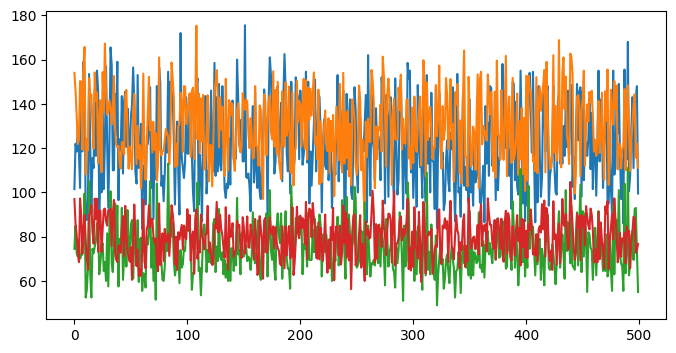

In [11]:
# show calibration-free results
print('calibration-free results')
err = estSBPAll-refSBPAll
MAE = np.average(np.abs(err))
print('SBP MAE: %.3f ME: %.3f STD: %.3f' % (MAE, np.average(err),np.std(err)))
plt.figure(figsize=(8,4))
plt.plot(refSBPAll)
plt.plot(estSBPAll)

err = estDBPAll-refDBPAll
MAE = np.average(np.abs(err))
print('DBP MAE: %.3f ME: %.3f STD: %.3f' % (MAE, np.average(err),np.std(err)))

plt.plot(refDBPAll)
plt.plot(estDBPAll)

calibration-based results
SBP MAE: 8.421 ME: 2.687 STD: 10.506
DBP MAE: 6.063 ME: 2.593 STD: 7.319


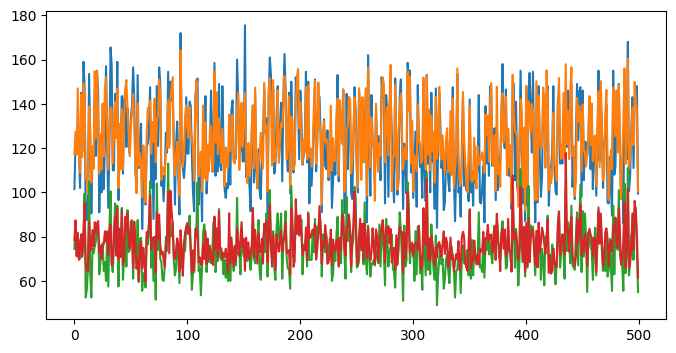

In [12]:
# show calibration-based results

print('calibration-based results')
rario = 0.3
estSBPAll_t = estSBPAll*rario+BaseSBPAll*(1-rario)
err = estSBPAll_t-refSBPAll
MAE = np.average(np.abs(err))
print('SBP MAE: %.3f ME: %.3f STD: %.3f' % (MAE, np.average(err),np.std(err)))
plt.figure(figsize=(8,4))
plt.plot(refSBPAll)
plt.plot(estSBPAll_t)

estDBPAll_t = estDBPAll*rario+BaseDBPAll*(1-rario)
err = estDBPAll_t-refDBPAll
MAE = np.average(np.abs(err))
print('DBP MAE: %.3f ME: %.3f STD: %.3f' % (MAE, np.average(err),np.std(err)))

plt.plot(refDBPAll)
plt.plot(estDBPAll_t)